In this notebook we construct a function to simulate images of lenses with convergence maps taken from Illustris and images from the PROBES dataset as sources. It's *nearly* as simple as possible: the one complexity is that the image is first simulated on a fine grid and then downsampled to the target one.

In [1]:
%load_ext autoreload
%autoreload 2

In [134]:
from math import pi

from astropy.visualization import make_lupton_rgb
from matplotlib.colors import CenteredNorm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from caustic.constants import rad_to_arcsec
from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.data import PROBESDataset, IllustrisKappaDataset
from caustic.lenses import KappaGrid
from caustic.parametrized import Parametrized
from caustic.sources import ImageSource, Sersic
from caustic.utils import get_meshgrid


device = "cpu"
kappa_path = "../../data/hkappa356hst_TNG100_rau_spl_trainset_0.5kpc_z0/data_1.h5"
probes_path = "../../data/probes.h5"

Create simulator. This indexes into the lens and source datasets, performs the ray-tracing and source interpolation, and downsamples.

In [3]:
ds_probes = PROBESDataset(probes_path)
ds_illustris = IllustrisKappaDataset(kappa_path)
cosmology = FlatLambdaCDMCosmology("cosmo")

z_s = torch.tensor(2.3, device=device)
z_l = torch.tensor(1.5, device=device)
pix_Mpc = 0.5 * 1e-3
n_pix = ds_illustris.n_pix
fov_Mpc = pix_Mpc * n_pix
fov = fov_Mpc / cosmology.angular_diameter_dist(z_l) * rad_to_arcsec
res = fov / n_pix

In [4]:
class Simulator(Parametrized):
    def __init__(
        self,
        name,
        cosmology,
        res,
        n_pix,
        z_l,
        z_s,
        upsample_factor=4,
        device=torch.device("cpu"),
    ):
        super().__init__(name)
        self.upsample_factor = upsample_factor
        self.add_param("z_s", torch.as_tensor(z_s, device=device))

        self._thx_fine, self._thy_fine = get_meshgrid(
            res / upsample_factor,
            upsample_factor * n_pix,
            upsample_factor * n_pix,
            device,
        )

        self.lens = KappaGrid(
            "kg",
            fov,
            n_pix,
            cosmology,
            z_l=z_l,
            kappa_map_shape=(n_pix, n_pix),
        )
        self.src = ImageSource(
            "img-src",
            thx0=torch.tensor(0.0, device=device),
            thy0=torch.tensor(0.0, device=device),
            scale=torch.tensor(1.0, device=device),
        )

    def __call__(self, x):
        x = self.x_to_dict(x)

        z_s = self.unpack(x)

        bx, by = self.lens.raytrace(self._thx_fine, self._thy_fine, z_s, x)
        mu_fine = self.src.brightness(bx, by, x)
        return F.avg_pool2d(mu_fine, self.upsample_factor)[0]

In [5]:
sim = Simulator("sim", cosmology, res, n_pix, z_l, z_s)

# For plotting
extent = (-fov / 2, fov / 2, -fov / 2, fov / 2)

In [6]:
print(sim)

Simulator(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('kg': ['kappa_map']), ('img-src': ['image'])]
)


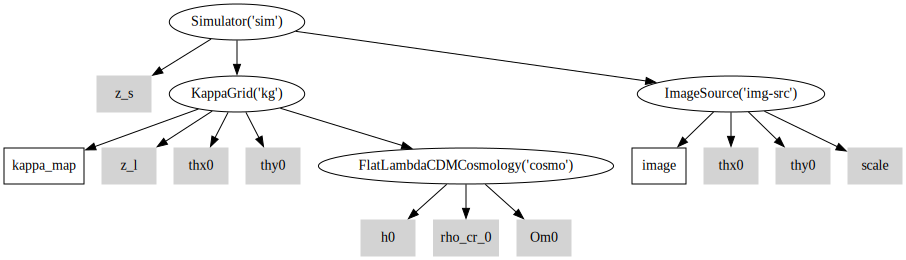

In [7]:
sim.get_graph(True, True)

Select random indices

In [8]:
idx_lens = torch.randint(len(ds_illustris), size=())
idx_src = torch.randint(len(ds_probes), size=())

In [39]:
idx_src = 14
idx_lens = 103

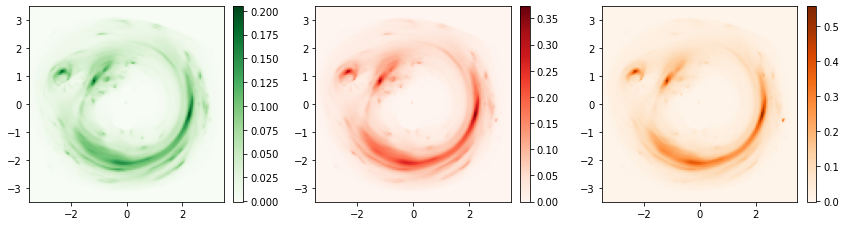

In [40]:
x = [ds_illustris[idx_lens][None, None], ds_probes[idx_src][None]]
image = sim(x)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.25))
for ax, channel, cmap in zip(axs, image, ["Greens", "Reds", "Oranges"]):
    im = ax.imshow(channel, extent=extent, origin="lower", cmap=cmap)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)

fig.tight_layout()

In [27]:
from matplotlib.colors import CenteredNorm

In [164]:
thx, thy = get_meshgrid(0.025, 200, 200)
sersic = Sersic(
    "sersic",
    torch.tensor(0.0),
    torch.tensor(0.0),
    torch.tensor(0.6),
    torch.tensor(-1.9),
    torch.tensor(1.9),
    torch.tensor(3.0),
    torch.tensor(1.0),
)

(-0.5, 199.5, 199.5, -0.5)

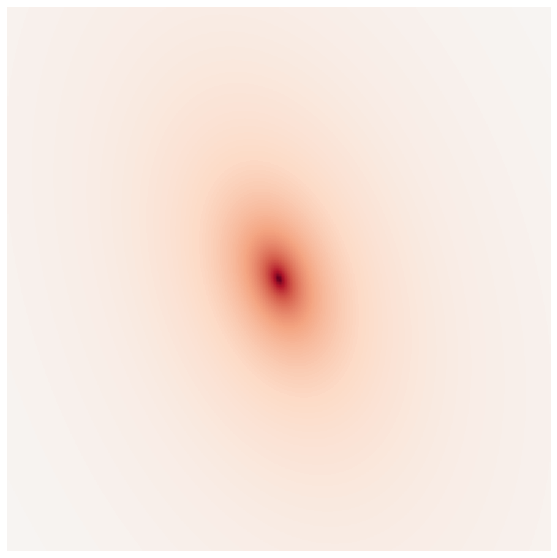

In [165]:
plt.figure(figsize=(10, 10))
plt.imshow(sersic.brightness(thx, thy, sersic.x_to_dict([])), cmap="RdBu_r", norm=CenteredNorm())
plt.gca().axis("off")

(-0.5, 255.5, 255.5, -0.5)

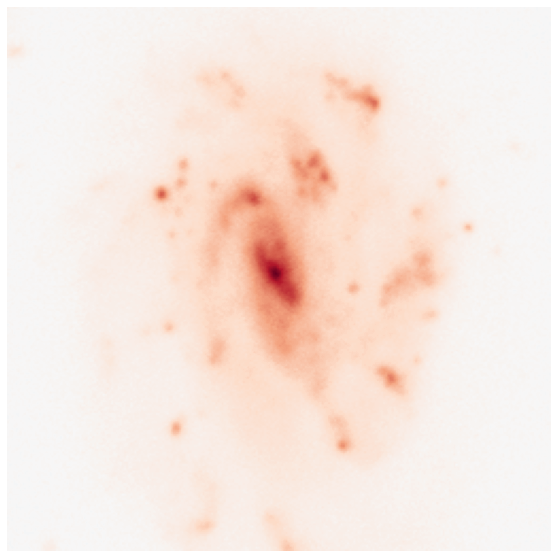

In [94]:
plt.figure(figsize=(10, 10))
src = ds_probes[idx_src][0]
plt.imshow(src, cmap="RdBu_r", norm=CenteredNorm())
plt.gca().axis("off")

(-0.5, 255.5, 255.5, -0.5)

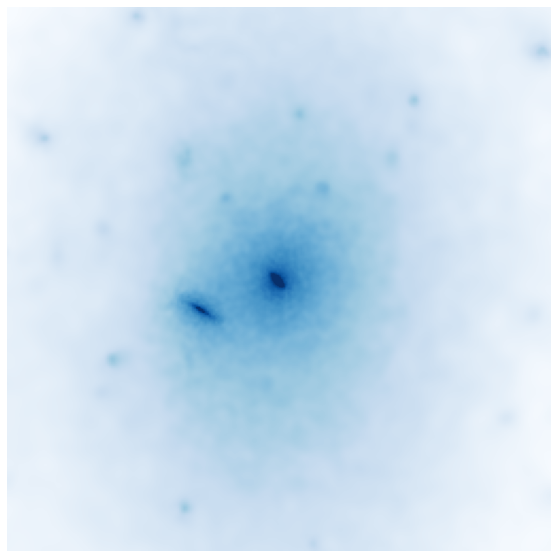

In [176]:
plt.figure(figsize=(10, 10))
kappa = ds_illustris[idx_lens]
plt.imshow(kappa.log(), cmap="Blues", vmin=-2.5, vmax=2)
plt.gca().axis("off")

In [106]:
from scipy.ndimage.filters import gaussian_filter

/var/folders/v9/zqb5zmx5745_zvvfkmgvj3jr0000gn/T/ipykernel_85930/2664825262.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


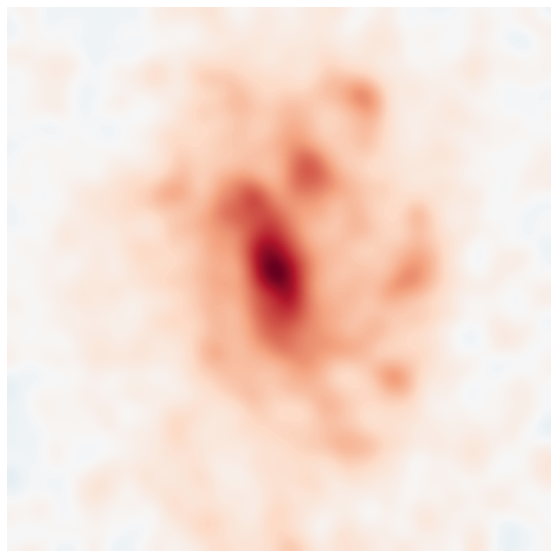

In [128]:
src = ds_probes[idx_src][0]
for i in range(15):
    recon = gaussian_filter(src + torch.randn_like(src) * 0.07, sigma=5)

    plt.figure(figsize=(10, 10))
    plt.imshow(recon, cmap="RdBu_r", norm=CenteredNorm())
    plt.gca().axis("off")
    plt.savefig(f"/Users/amcoogan/Downloads/fake-recons/recon-{i}.png")
    break

(-3.5, 3.5)

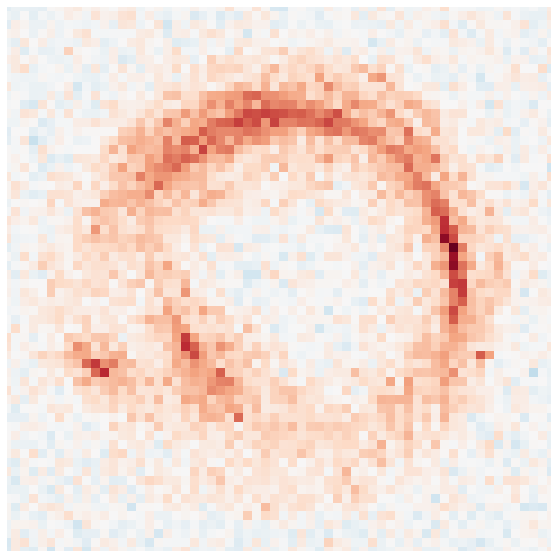

In [133]:
plt.figure(figsize=(10, 10))
image_small = torch.nn.functional.avg_pool2d(image[0][None, None], 2, 2)[0, 0]
plt.imshow(image_small + torch.randn_like(image_small) * 0.015, extent=extent, cmap="RdBu_r", norm=CenteredNorm())
plt.gca().axis("off")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

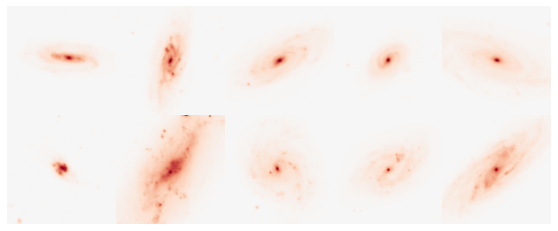

In [85]:
fig, axes = plt.subplots(2, 5, figsize=(9.75, 4))
n = axes.size
idxs = [
    # 180, 181, 182, 184, 185,
    186, 188, 190, 191, 192,
    195, 194, 196, 202, 198
]
for gal, ax in zip(ds_probes[idxs][0], axes.flatten()):
    ax.imshow(gal, cmap="RdBu_r", norm=CenteredNorm())
    ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)